### Helpful Links:

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

In [1]:
%config InlineBackend.figure_format = 'retina'

# import dependencies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Load and sort the dataframe.
df = pd.read_csv('strand-matthew.csv', parse_dates=['Date'], index_col='Date')
df_dv = df.filter(['Date', 'ASP'])
df_dv.head()

,ASP
Date,
2020-02-06,7778.96
2020-03-24,2749.92
2020-03-07,2749.92
2020-02-08,2749.92
2020-02-07,2200.00


In [3]:
# resample stationary data to monthly since there are missing dates due to weekends
df_m = df_dv['ASP'].resample('M').mean()
df_m.head()

Date
2015-01-31    674.135718
2015-02-28    602.409461
2015-03-31    611.416775
2015-04-30    612.819200
2015-05-31    618.466260
Freq: M, Name: ASP, dtype: float64

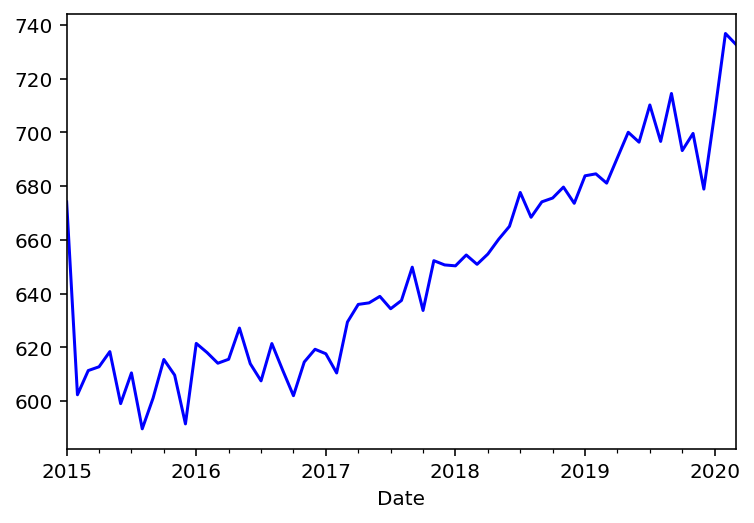

In [4]:
# chart the initial monthly data and do a prelimiary test to see if it's stationary 
fig, ax = plt.subplots()
df_m.plot(ax=ax, color = 'blue')
plt.show()

In [5]:
# ADF test #1
result = adfuller(df['ASP'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -24.2139103661795
p-value: 0.0
Critical Values:
	1%: -3.4303754087168254
	5%: -2.8615512303304302
	10%: -2.566775977498725


In [6]:
# take the difference from previous time period (added .diff x2 after inital dickey/fuller test was lower than expected)
df_stationary = df_dv.diff().diff().dropna()
df_stationary.head()

,ASP
Date,
2020-03-07,5029.04
2020-02-08,0.00
2020-02-07,-549.92
2020-03-20,461.92
2020-03-20,88.00


In [7]:
# ADF test #2
result = adfuller(df_stationary['ASP'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -115.85658110796126
p-value: 0.0
Critical Values:
	1%: -3.43037540891428
	5%: -2.8615512304177027
	10%: -2.566775977545177


In [8]:
# resample stationary data to monthly since there are missing dates due to weekends
df_m = df_stationary['ASP'].resample('M').mean()

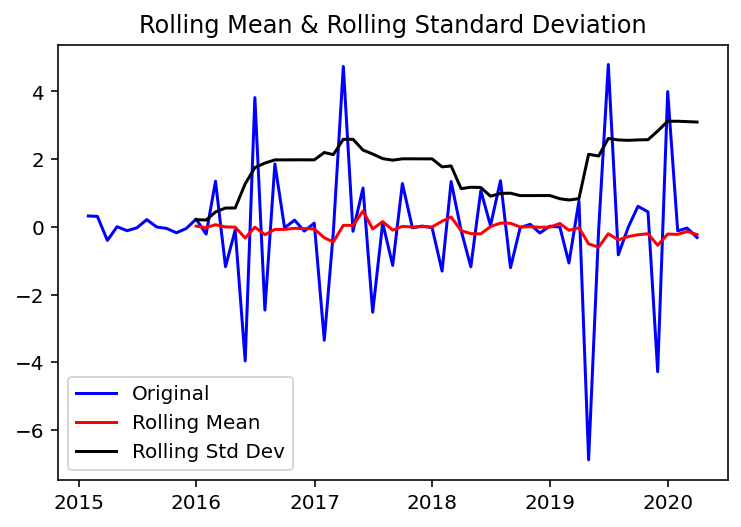

In [16]:
# take the rolling mean and std deviation and compare to stationary data for final check
rolling_mean = df_m.rolling(window = 12).mean()
rolling_std = df_m.rolling(window = 12).std()
plt.plot(df_m, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std Dev')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [36]:
# Train data - all data up to the end of 2017
df_train = df_m.loc[:'2017']

# Test data - 2018 + 2019
df_test = df_m.loc['2018':'2020-03-31']
# df_test_18.head()

df_train.head()

Date
2015-01-31    0.320526
2015-02-28    0.309635
2015-03-31   -0.401563
2015-04-30    0.003932
2015-05-31   -0.114749
Freq: M, Name: ASP, dtype: float64

(array([735599., 735719., 735842., 735964., 736085., 736208., 736330.,
        736450., 736573., 736695.]),
 <a list of 10 Text major ticklabel objects>)

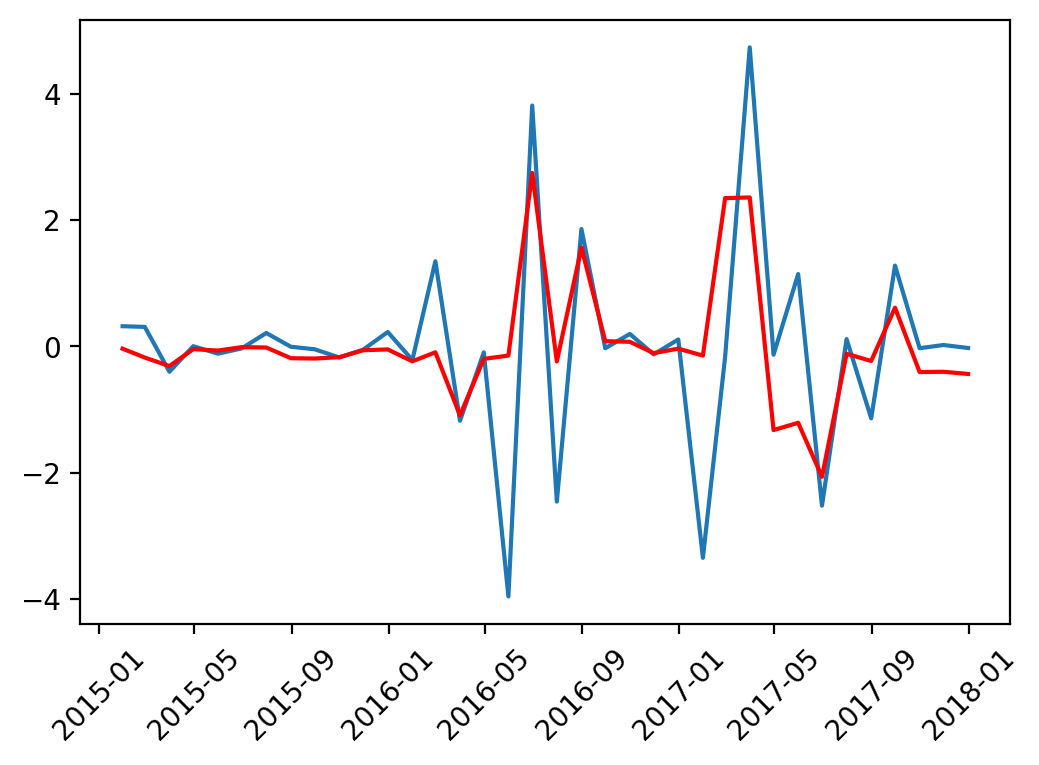

In [41]:
decomposition = seasonal_decompose(df_train) 
model = ARIMA(df_train, order=(1,0,1))
results = model.fit(disp=-1)
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(df_m.loc[:'2017'])
plt.plot(results.fittedvalues, color='red')
plt.xticks(rotation=45)

(array([552, 564, 576]), <a list of 3 Text major ticklabel objects>)

<Figure size 600x400 with 0 Axes>

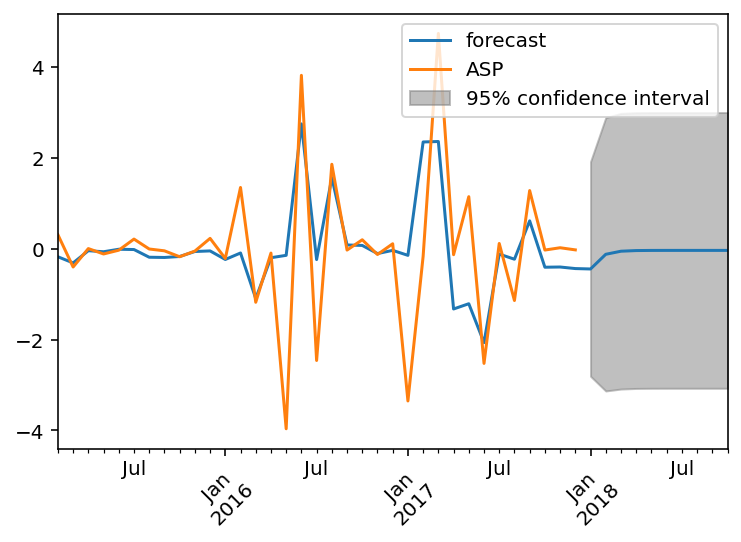

In [42]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_train.iloc[0], index=df_train.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(6, 4), dpi=100)
results.plot_predict(1,45)
plt.xticks(rotation=45)

(array([736695., 736785., 736876., 736968., 737060., 737150., 737241.,
        737333., 737425., 737516.]),
 <a list of 10 Text major ticklabel objects>)

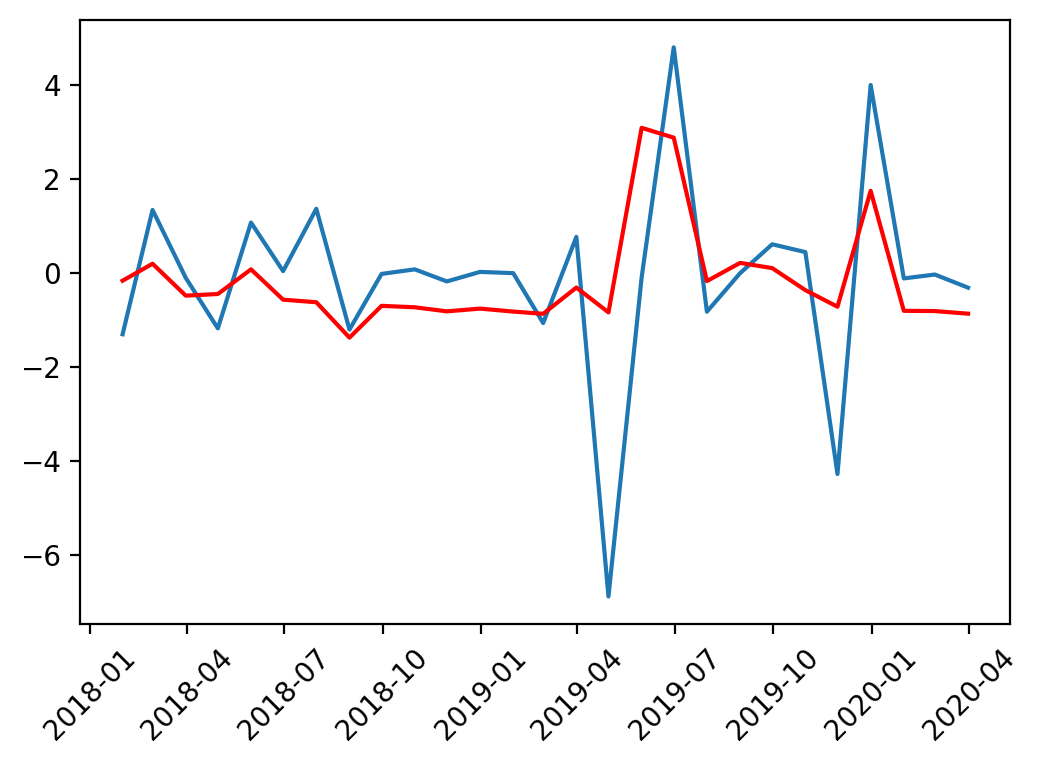

In [43]:
decomposition = seasonal_decompose(df_test) 
model = ARIMA(df_test, order=(1,0,1))
results = model.fit(disp=1)
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(df_m.loc['2018':'2020-03-31'])
plt.plot(results.fittedvalues, color='red')
plt.xticks(rotation=45)

(array([588, 600, 612]), <a list of 3 Text major ticklabel objects>)

<Figure size 600x400 with 0 Axes>

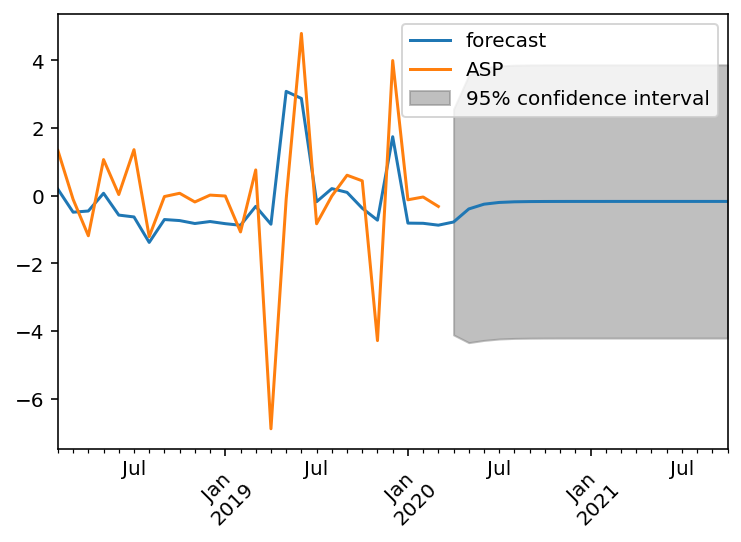

In [47]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_test.iloc[0], index=df_test.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(6, 4), dpi=100)
results.plot_predict(1,45)
plt.xticks(rotation=45)

(array([552, 564, 576, 588, 600, 612]),
 <a list of 6 Text major ticklabel objects>)

<Figure size 600x400 with 0 Axes>

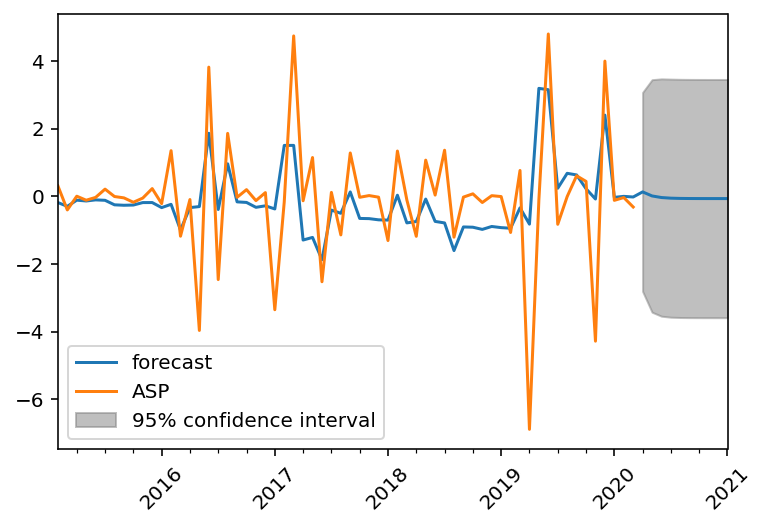

In [76]:
# fit historical data
decomposition = seasonal_decompose(df_m) 
model = ARIMA(df_m, order=(1,0,1))
results = model.fit(disp=1)

#
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_m.iloc[0], index=df_m.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(6, 4), dpi=100)
results.plot_predict(1,72)
plt.xticks(rotation=45)

In [80]:
projected_sales = [552, 564, 576, 588, 600, 612]
analysis_df = pd.DataFrame(projected_sales) 
analysis_df.head()

,0
0,552
1,564
2,576
3,588
4,600


#### Final Thoughts
In my forecasting effort I used an ARIMA model to forecast future income from our largest product line to provide initial analysis on cash flow and overall company stability. ARIMA is a model that removes the trend component in order to accurately predict future values.

Outcomes from the model put us at a confidence interval of around 89% with expected growth at $12M in revenue growth for our largest and most profitable product line from the previous years' sales, this is a 2.2% growth rate year over year. While this is not meeting our pre-2020 goals/projections, this is a solid growth number in the current economic climate where many companies are making very hard decisions and restricting thier businesses in order to protect it from economic impact.